# Post-processing with FESTIM: derived quantities
In this tutorial, we will show the wide range of derived quantities that can be computed as a post process in FESTIM and how to plot them with matplotlib.

## 1. Problem definition

The test case for this tutorial will be a 2D composite domain with 2 traps.

 <p align="center">
  <img src="https://user-images.githubusercontent.com/40028739/104911125-a85da380-598a-11eb-9ba2-9e105f478759.jpg" width="40%">
</p>


- $\Omega = [0;10^{-7}] \times [0;10^{-7}]$
- $\Omega_2 = [5\times 10^{-8};10^{-7}] \times [5\times 10^{-8};10^{-7}]$
- $\Omega_1 = \Omega \; / \; \Omega_2$
- $D(T) = \begin{cases}
    4.1\times 10^{-7} \exp{(-0.39/k_B T)}, & \text{on } \Omega_1\\
    5.0\times 10^{-7} \exp{(-0.50/k_B T)}, & \text{on } \Omega_2
    \end{cases}$
- Trap 1 in $\Omega_1$:
    - Density: $n_1 = 6\times 10^{25} \text{ m}^{-3}$
    - Trapping rate: $k(T) = 3.8 \times 10^{-17} \exp{(-0.39/k_B T)} \text{ s}^{-1}$
    - Detrapping rate: $p(T) = 10^{13} \exp{(-0.87/k_B T)} \text{ s}^{-1}$
- Trap 2 in $\Omega_2$:
    - Density: $n_2 = 6\times 10^{25} \text{ m}^{-3}$
    - Trapping rate: $k(T) = 3.8 \times 10^{-17} \exp{(-0.39/k_B T)} \text{ s}^{-1}$
    - Detrapping rate: $p(T) = 10^{13} \exp{(-1.0/k_B T)} \text{ s}^{-1}$

Two Dirichlet boundary conditions will be imposed on $\Gamma_\mathrm{left}$ and $\Gamma_\mathrm{bottom}$.

- $c_\mathrm{m} = 10^{15} \; \mathrm{m}^{-3} \quad \text{on } \Gamma_\mathrm{left}$
- $c_\mathrm{m} = 0 \; \mathrm{m}^{-3} \quad \text{on }\Gamma_\mathrm{bottom}$

All the other surfaces are insulated ($\nabla c_\mathrm{m} \cdot n = 0$).

## 2. Implementation
First, the main parameters dictionnary needs to be initialised.

In [1]:
parameters = {}

Then, let's create a mesh using FEniCS commands.

In [2]:
from fenics import Point, RectangleMesh, CompiledSubDomain, MeshFunction

# creating a 2D mesh with FEniCS
nx = ny = 14
mesh_fenics = RectangleMesh(Point(0, 0), Point(1e-7, 1e-7), nx, ny)

# marking volumes
volume_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim())

volume_markers.set_all(1)

tol = 1e-14

subdomain_2 = CompiledSubDomain('x[1] >= 0.5e-7 - tol && x[0] >= 0.5e-7 - tol', tol=tol)
subdomain_2.mark(volume_markers, 2)

# marking surfaces
surface_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)

left_surface = CompiledSubDomain('on_boundary && near(x[0], 0, tol)',
                                tol=tol)
bottom_surface = CompiledSubDomain('on_boundary && near(x[1], 0, tol)',
                                     tol=tol)
surface_markers.set_all(0)
left_surface.mark(surface_markers, 1)
bottom_surface.mark(surface_markers, 2)

# creating mesh with FESTIM
parameters["mesh_parameters"] = {
    "mesh": mesh_fenics,
    "volume_markers": volume_markers,
    "surface_markers": surface_markers,
}

The two materials will have different diffusion coefficients.

In [3]:
parameters["materials"] = [{
    "E_D": 0.39,
    "D_0": 4.1e-7,
    "id": 1
},
    {
    "E_D": 0.5,
    "D_0": 5e-7,
    "id": 2
},
]

The same traps as in the Ogorodnikova demo will be used.

In [4]:
parameters["traps"] = [
        {
            "k_0": 3.8e-17,
            "E_k": 0.39,
            "p_0": 1e13,
            "E_p": 0.87,
            "density": 6e25,
            "materials": [1]
        },
        {
            "k_0": 3.8e-17,
            "E_k": 0.39,
            "p_0": 1e13,
            "E_p": 1.0,
            "density": 5e24,
            "materials": [2]
        },
]

Two Dirichlet boundary conditions will be imposed on $\Gamma_\mathrm{left}$ (id 1) and $\Gamma_\mathrm{bottom}$ (id 2).

- $c_\mathrm{m} = 10^{15} \; \mathrm{m}^{-3} \text{  on } \Gamma_\mathrm{left}$
- $c_\mathrm{m} = 0 \; \mathrm{m}^{-3} \text{  on }\Gamma_\mathrm{bottom}$

All the other surfaces are insulated ($\nabla c_\mathrm{m} \cdot n = 0$).

In [5]:
parameters["boundary_conditions"] = [
            {
                "surfaces": [1],
                "value": 1e15,
                "type": "dc"
            },
            {
                "surfaces": [2],
                "value": 0,
                "type": "dc"
            },
    ]

The temperature will increase linearly with time: $T(t) = 400 + 3t$ 

In [6]:
from FESTIM import t

parameters["temperature"] = {
    "type": "expression",
    "value": 400 + 3*t
    }

In [7]:
solving_parameters = {
    "final_time": 10,
    "initial_stepsize": 0.005,
    "adaptive_stepsize": {
        "stepsize_change_ratio": 1.1,
        "dt_min": 1e-5
    },
    "newton_solver": {
        "absolute_tolerance": 1e0,
        "relative_tolerance": 1e-9,
        "maximum_iterations": 50,
    },
    "traps_element_type": "DG",
}

parameters["solving_parameters"] = solving_parameters

FESTIM can provide a wide range of post-processing quantities called "derived quantities".
They include:
- Volume integration (`"total_volume"`)
- Surface integration (`"total_surface"`)
- Surface fluxes (`"surface_flux"`)
    - Heat fluxes : $ \varphi = \int -\lambda \nabla T \cdot n \; dS $
    - Particle fluxes : $ \varphi = \int -D \nabla c_\mathrm{m} \cdot n \; dS $
- Average value on volumes (`"average_volume"`)
- Minimum/maximum on volumes (`"minimum_volume"`, `"maximum_volume"`)

In [8]:
exports = {
    "derived_quantities": {
        "folder": 'solution_derived_quantities',
        "file": "derived_quantities.csv",
        "total_volume": [
            {
                "field": "solute",
                "volumes": [1, 2]
            },
            {
                "field": 1,
                "volumes": [1]
            },
            {
                "field": 2,
                "volumes": [2]
            },
            {
                "field": "retention",
                "volumes": [1, 2]
            },
        ],
        "surface_flux": [
            {
                "field": "solute",
                "surfaces": [0, 1, 2]
            },
        ],
        "average_volume": [
            {
                "field": "solute",
                "volumes": [1, 2]
            },
            {
                "field": "1",
                "volumes": [1]
            },
            {
                "field": "2",
                "volumes": [2]
            },
            {
                "field": "T",
                "volumes": [1]
            }
        ],
        "total_surface": [
            {
                "field": "solute",
                "surfaces": [0, 1, 2]
            }
        ],
        "maximum_volume": [
            {
                "field": "retention",
                "volumes": [1, 2]
            }
        ]
    },
}

parameters["exports"] = exports

Now that all the parameters have been set, the simulation can be performed using the `run()` function which takes as only argument the dict `parameters`.

In [9]:
from FESTIM.generic_simulation import run

output = run(parameters)

Defining initial values
Defining variational problem
Defining boundary conditions
Time stepping...


## 3. Post-processing
Now that the simulation is over, the derived quantities are stored in `output` and have been exported as a CSV file.

In [17]:
import numpy as np
header = output["derived_quantities"][0]
derived_quantities = np.array(output["derived_quantities"][1:])

print(header)
print(derived_quantities)

['t(s)', 'Flux surface 0: solute', 'Flux surface 1: solute', 'Flux surface 2: solute', 'Average solute volume 1', 'Average solute volume 2', 'Average 1 volume 1', 'Average 2 volume 2', 'Average T volume 1', 'Maximum retention volume 1', 'Maximum retention volume 2', 'Total solute volume 1', 'Total solute volume 2', 'Total 1 volume 1', 'Total 2 volume 2', 'Total retention volume 1', 'Total retention volume 2', 'Total solute surface 0', 'Total solute surface 1', 'Total solute surface 2']
[[  5.00000000e-03  -4.72860663e+01   2.66012155e+04 ...,   1.73502290e+07
    9.64285714e+07   0.00000000e+00]
 [  1.05000000e-02  -3.67130694e+01   2.31019195e+04 ...,   2.10825708e+07
    9.64285714e+07   0.00000000e+00]
 [  1.65500000e-02  -3.04443084e+01   2.03455786e+04 ...,   2.46904951e+07
    9.64285714e+07   0.00000000e+00]
 ..., 
 [  8.54359739e+00   4.36023326e+00   1.81899715e+04 ...,   1.02450080e+08
    9.64285714e+07   0.00000000e+00]
 [  9.40295712e+00   3.81278098e+00   1.94059923e+04 .

Alternatively, the derived quantities can be read from the exported CSV file.

In [11]:
derived_quantities_from_file = np.genfromtxt("solution_derived_quantities/derived_quantities.csv", delimiter=',', names=True)

These derived quantities can be analysed and plotted using matplotlib (or some other visualisation tool).

Below are some examples.

**Plotting inventories**

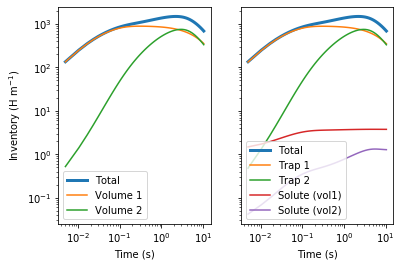

In [12]:
t = derived_quantities[:, output["derived_quantities"][0].index("t(s)")]


retention_1 = derived_quantities[:, header.index('Total retention volume 1')]
retention_2 = derived_quantities[:, header.index('Total retention volume 2')]

trap_1 = derived_quantities[:, header.index('Total 1 volume 1')]
trap_2 = derived_quantities[:, header.index('Total 2 volume 2')]

solute_1 = derived_quantities[:, header.index('Total solute volume 1')]
solute_2 = derived_quantities[:, header.index('Total solute volume 2')]

# plot
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(t, retention_1 + retention_2, linewidth=3, label="Total")
ax1.plot(t, retention_1, label="Volume 1")
ax1.plot(t, retention_2, label="Volume 2")
ax1.set_ylabel(r"Inventory (H m$^{-1}$)")
ax1.set_xlabel(r"Time (s)")
ax1.set_xscale("log")
ax1.legend()

ax2.plot(t, retention_1 + retention_2, linewidth=3, label="Total")
ax2.plot(t, trap_1, label="Trap 1")
ax2.plot(t, trap_2, label="Trap 2")
ax2.plot(t, solute_1, label="Solute (vol1)")
ax2.plot(t, solute_2, label="Solute (vol2)")
ax2.set_xlabel(r"Time (s)")
ax2.legend()
ax2.set_xscale("log")

ax1.set_yscale("log")

**Plotting fluxes**

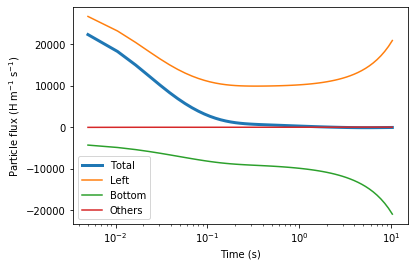

In [13]:
flux_other_surfaces = derived_quantities[:, header.index('Flux surface 0: solute')]
flux_left = derived_quantities[:, header.index('Flux surface 1: solute')]
flux_bottom = derived_quantities[:, header.index('Flux surface 2: solute')]
flux_total = flux_left + flux_bottom + flux_other_surfaces

plt.figure()
plt.plot(t, flux_total, linewidth=3, label="Total")
plt.plot(t, flux_left, label="Left")
plt.plot(t, flux_bottom, label="Bottom")
plt.plot(t, flux_other_surfaces, label="Others")
plt.ylabel(r"Particle flux (H m$^{-1}$ s$^{-1}$)")
plt.xlabel(r"Time (s)")
plt.xscale("log")
plt.legend()

**Plotting maximum retention**

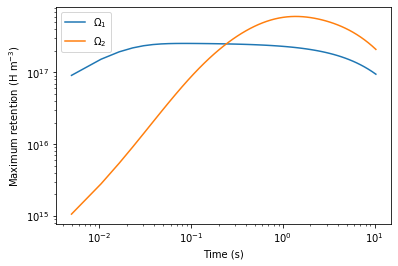

In [14]:
max_1 = derived_quantities[:, header.index('Maximum retention volume 1')]
max_2 = derived_quantities[:, header.index('Maximum retention volume 2')]

plt.figure()
plt.loglog(t, max_1, label="$\Omega_1$")
plt.loglog(t, max_2, label="$\Omega_2$")
plt.ylabel(r"Maximum retention (H m$^{-3}$)")
plt.xlabel(r"Time (s)")
plt.legend()

**Ploting average temperature**

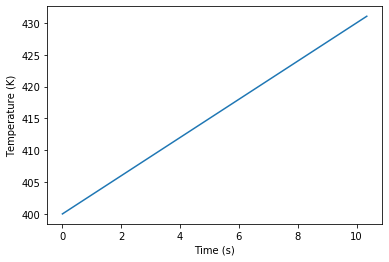

In [15]:
T = derived_quantities[:, header.index('Average T volume 1')]

plt.figure()
plt.plot(t, T)
plt.ylabel(r"Temperature (K)")
plt.xlabel(r"Time (s)")

**Plotting inventory on surfaces**

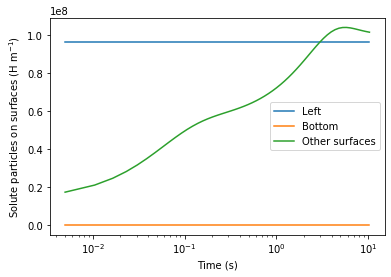

In [16]:
solute_surf_0 = derived_quantities[:, header.index('Total solute surface 0')]
solute_surf_1 = derived_quantities[:, header.index('Total solute surface 1')]
solute_surf_2 = derived_quantities[:, header.index('Total solute surface 2')]

plt.figure()
plt.plot(t, solute_surf_1, label="Left")
plt.plot(t, solute_surf_2, label="Bottom")
plt.plot(t, solute_surf_0, label="Other surfaces")
plt.ylabel(r"Solute particles on surfaces (H m$^{-1}$)")
plt.xlabel(r"Time (s)")
plt.xscale("log")
plt.legend()